In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
import joblib

In [2]:
from utils_custom import *

In [3]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(output_folder, 'dynamic.h5'))

# Visualize custom TFs

PlasmaBlast


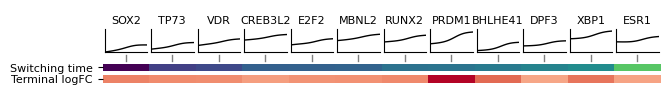

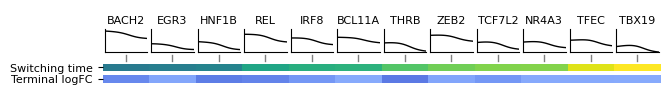

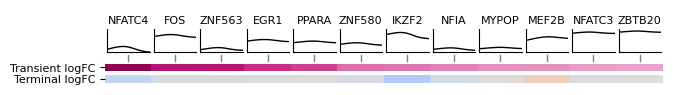

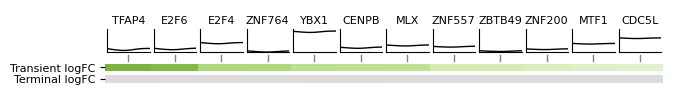

GerminalCenter


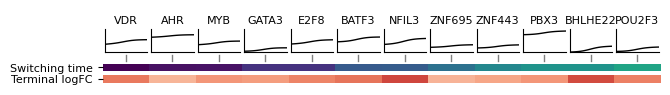

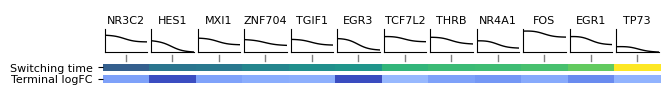

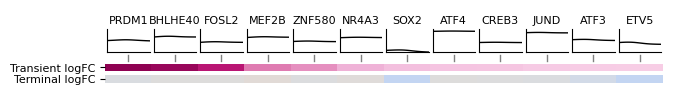

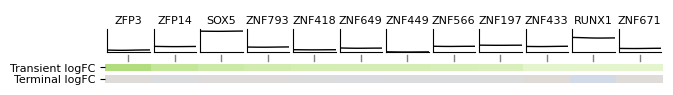

In [5]:
#Trajectory branch defined as (starting node, ending node) from trajectory inference
#See main1.ipynb
branches={
	'PlasmaBlast':(0,2),
	'GerminalCenter':(0,3)
}

for branchname in branches:
	print(branchname)
	figs=dictys_dynamic_object.draw_discover(*branches[branchname],ntops=(12,12,12,12),num=20,dist=0.001,mode='TF_expression')
	plt.show()

In [6]:
custom_tfs = ['BACH2','CREB3L2', 'NFKB1','TFEC','EP2','PRDM1','XBP1','PAX5','IRF4']
tf_indices_custom, tf_gene_indices_custom, missing_tfs = get_tf_indices(dictys_dynamic_object, custom_tfs)
display(tf_indices_custom)
display(missing_tfs) #not present in the motif databases, hence not in the final GRN. QC filtering has been masked for important genes to not dropout.

[16, 36, 187, 290, 225, 305, 208, 118]

['EP2']

In [7]:
custom_lf_pairs = [('PBX3','PAX5'),('RFX3','CEP128'),('CREB3L2','FNDC3A'),('CREB3L2','TXNDC5'),('CREB3L2','TRAM1'),('PAX5','RUNX2')]

In [8]:
custom_tf_links = [('IRF4','TCF4'),('IRF4', 'BCL11A'),('IRF4','PAX5'),('IRF4','RUNX2'),('SPIB','TCF4'),('SPIB','STAT1'),('SPIB','AHR'),('SPIB','KLF2'),('PRDM1','IKZF2'),('PRDM1','NR4A2'),('PRDM1','HNF1B'),('PRDM1','MYC'),('IRF4','MYC'),('PRDM1','IL2RA'),('PRDM1','CCND2'),('IRF4','CCND2'),('IRF4','IL2RA')]

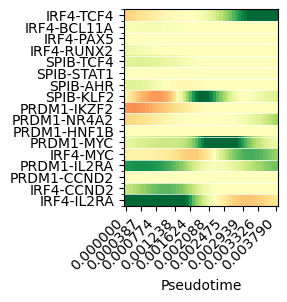

In [13]:
# plot the heatmap of the cell-cycle pairs
fig, ax, dnet = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=custom_tf_links,
    num=50,
    dist=0.0005,
    cmap='RdYlGn' #red is low, green is high
)

In [11]:
print("Original dnet values range:", dnet.min(), "to", dnet.max())
# Convert dnet to DataFrame with row labels
df = pd.DataFrame(dnet, 
                 index=["-".join(x) for x in custom_tf_links])
print("DataFrame values range:", df.values.min(), "to", df.values.max())
# Calculate max absolute value for symmetric color scaling
vmax_val = float(df.abs().values.max())  # Get max from numpy array values

Original dnet values range: -0.054579133260743096 to 0.22368868956434787
DataFrame values range: -0.054579133260743096 to 0.22368868956434787


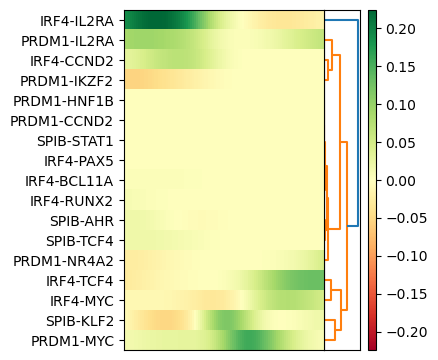

In [12]:
# Use cluster_heatmap with absolute values for clustering
fig, x, y = cluster_heatmap(df.abs(),  # Use absolute values for clustering
                           dshow=df,    # Show original values in heatmap
                           dtop=0,      # No clustering on time points
                           dright=0.3,  # Cluster the links
                           method='ward',
                           metric='euclidean',
                           cmap='RdYlGn',   # Use the colormap name directly
                           aspect=0.1,
                           xtick=False,
                           vmin=-vmax_val,  # Set minimum value
                           vmax=vmax_val)   # Set maximum value

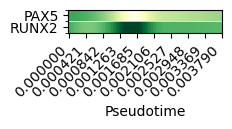

In [13]:
# plot expression gradient of RUNX2
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    genes_or_regulations=['PAX5', 'RUNX2'],
    num=100,
    dist=0.0005,
    cmap='YlGn' # green is positive yellow is negative
)


#### Get curve characteristics like regulation, expression, etc.

In [14]:
# get line plots for pax5, runx2
# Call compute_chars for expression mode
dy_pb, dx_pb = compute_expression_regulation_curves(dictys_dynamic_object,
    start=0,          # Starting node ID
    stop=2,           # Ending node ID
    num=100,          # Number of points to interpolate
    dist=0.0005,      # Smoothing distance
    mode='expression' # Use expression (CPM) mode
)


In [15]:
# Calculate gradients for all genes
gradients_df_pb = pd.DataFrame(
    np.vstack([np.gradient(dy_pb.loc[gene].values, dx_pb.values) for gene in dy_pb.index]),
    columns=dy_pb.columns,
    index=dy_pb.index
)

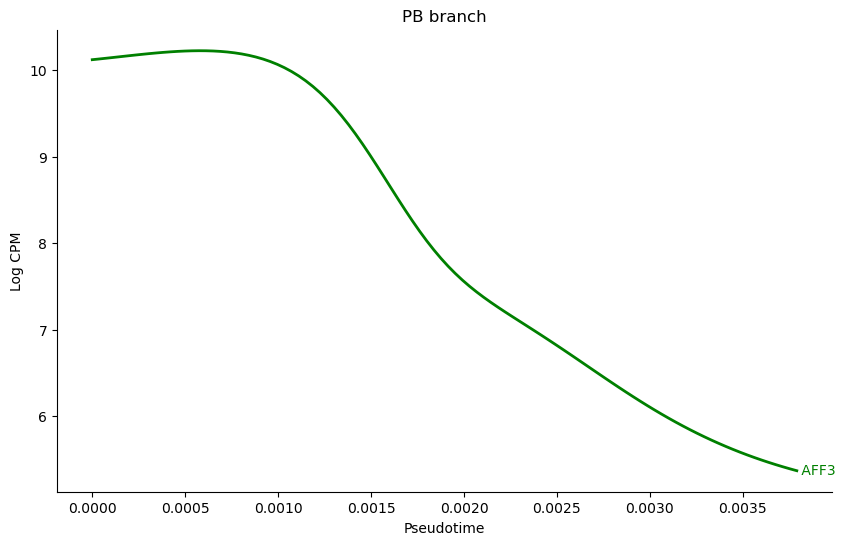

In [16]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
genes_of_interest = ['AFF3']
colors = ['green']   # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in dy_pb.index:
        line = plt.plot(dx_pb, dy_pb.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dx_pb.iloc[-1], dy_pb.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Log CPM')
plt.title('PB branch')
plt.show()

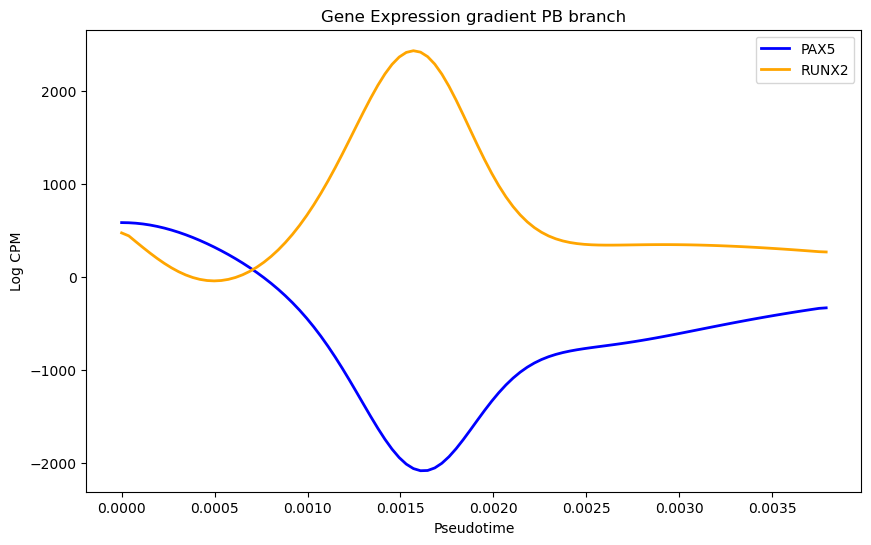

In [17]:
# Plot expression trajectories
plt.figure(figsize=(10, 6))

# Highlight specific genes
genes_of_interest = ['PAX5', 'RUNX2']
colors = ['blue', 'orange']  # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in gradients_df_pb.index:
        plt.plot(dx_pb, gradients_df_pb.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Log CPM')
plt.title('Gene Expression gradient PB branch')
plt.legend()
plt.show()

# Animations

In [21]:
pairs = [('PBX3','PAX5'), ('NRF1','PAX5'),('NRF1','RUNX2'),('PAX5','RUNX2')]

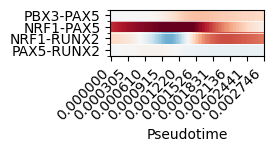

In [18]:
# plot the heatmap of the lineage pairs
fig, ax_gc, cmap = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    regulations=pairs,
    num=100,
    dist=0.0005,
    cmap='RdBu'
)

In [23]:
# Get the raw data from heatmap
heatmap_data_gc = ax_gc.images[0].get_array()

# Get unique TFs and targets from cell_cycle_pairs
tfs_gc = list(set(pair[0] for pair in pairs))
targets_gc = list(set(pair[1] for pair in pairs))

# Function to convert RdBu colors to regulation strength
def rdbu_to_regulation(rgb_values):
    # In RdBu, red indicates positive regulation (R > B)
    # and blue indicates negative regulation (B > R)
    return rgb_values[:, 0] - rgb_values[:, 2]  # R - B gives regulation strength

# Create a dictionary to store actual regulation values
regulation_dict_gc = {}
for row_idx, (tf, target) in enumerate(pairs):
    # Convert RGB values to regulation strength
    regulation_strength = rdbu_to_regulation(heatmap_data_gc[row_idx])
    regulation_dict_gc[(tf, target)] = regulation_strength

# Create 3D array (n_tf x n_target x n_timepoints)
regulation_array_gc = np.zeros((len(tfs_gc), len(targets_gc), heatmap_data_gc.shape[1]))
for tf_idx, tf in enumerate(tfs_gc):
    for target_idx, target in enumerate(targets_gc):
        if (tf, target) in regulation_dict_gc:
            regulation_array_gc[tf_idx, target_idx, :] = regulation_dict_gc[(tf, target)]

print("\nFinal array shape:", regulation_array_gc.shape)
print("TFs:", tfs_gc)
print("Targets:", targets_gc)


Final array shape: (3, 2, 100)
TFs: ['NRF1', 'PAX5', 'PBX3']
Targets: ['PAX5', 'RUNX2']


#### Animate the subgraph of the mentioned regulations

In [25]:
# get the weights of the lineage pairs across windows
tf_indices_lineage, tf_gene_indices_lineage, _ = get_tf_indices(dictys_dynamic_object, [pair[0] for pair in pairs])
gene_indices_lineage = get_gene_indices(dictys_dynamic_object, [pair[1] for pair in pairs])


In [26]:
import networkx as nx
import matplotlib.animation as animation
from matplotlib.patches import ArrowStyle, ConnectionStyle
import matplotlib.pyplot as plt

def create_network_animation(weights, tf_names, target_names, output_path, branch_name):
    """
    Create and save network animation showing weight changes across windows.
    Node positions remain fixed, only edge weights change.
    """
    n_tfs, n_targets, n_windows = weights.shape
    
    # Create initial graph with all possible nodes and edges
    G_init = nx.DiGraph()
    
    # Add TF nodes
    for tf in tf_names:
        G_init.add_node(tf, node_type='TF')
        
    # Add target nodes
    for target in target_names:
        G_init.add_node(target, node_type='target')
    
    # Calculate fixed layout once
    pos = nx.spring_layout(G_init, k=1, iterations=50)
    
    def create_graph(window_idx):
        G = G_init.copy()
        
        # Add edges with weights for this window
        for i, tf in enumerate(tf_names):
            for j, target in enumerate(target_names):
                weight = weights[i, j, window_idx]
                if abs(weight) > 0.1:  # Only show stronger connections
                    G.add_edge(tf, target, weight=weight)
        
        return G
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    def update(frame):
        ax.clear()
        G = create_graph(frame)
        
        # Draw nodes using fixed positions
        tf_nodes = [n for n, attr in G.nodes(data=True) if attr['node_type'] == 'TF']
        target_nodes = [n for n, attr in G.nodes(data=True) if attr['node_type'] == 'target']
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, nodelist=tf_nodes, node_color='lightblue', 
                             node_size=1000, label='TFs')
        nx.draw_networkx_nodes(G, pos, nodelist=target_nodes, node_color='lightgreen',
                             node_size=1000, label='Targets')
        
        # Draw edges with different styles based on weight
        edges = G.edges(data=True)
        if edges:
            # Separate positive and negative edges with their weights
            pos_edges = [(u, v, abs(d['weight'])) for (u, v, d) in edges if d['weight'] > 0]
            neg_edges = [(u, v, abs(d['weight'])) for (u, v, d) in edges if d['weight'] < 0]
            
            # Function to scale edge widths (min width 1, max width 5)
            def scale_width(weight):
                return 1 + 4 * (weight - 0.1) / (2.0 - 0.1)
            
            # Draw positive edges with arrow
            if pos_edges:
                nx.draw_networkx_edges(G, pos, 
                                     edgelist=[(u,v) for u,v,w in pos_edges], 
                                     edge_color='red',
                                     arrows=True,
                                     arrowsize=20,
                                     width=[scale_width(w) for _,_,w in pos_edges],
                                     arrowstyle='->')
            
            # Draw negative edges with custom repression style
            if neg_edges:
                nx.draw_networkx_edges(G, pos, 
                                     edgelist=[(u,v) for u,v,w in neg_edges],
                                     edge_color='blue',
                                     arrows=True,
                                     arrowsize=20,
                                     width=[scale_width(w) for _,_,w in neg_edges],
                                     arrowstyle='->')
        
        # Add labels with fixed positions
        nx.draw_networkx_labels(G, pos)
        
        # Add title and window info
        plt.title(f'Window {frame + 1}/{n_windows}')
        
        # Add legend with smaller markers
        plt.legend(markerscale=0.5, prop={'size': 8})
        
        return ax

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=n_windows, 
                                 interval=200, blit=False)
    
    # Save animation
    output_file = os.path.join(output_path, f'network_animation_{branch_name}.mp4')
    anim.save(output_file, writer='ffmpeg', fps=15)
    plt.close()
    
    return output_file

In [27]:
# First, let's verify our data
print("Regulation array shape:", regulation_array_gc.shape)
print("TFs:", tfs_gc)
print("Targets:", targets_gc)
print("Lineage pairs:", pairs)

# Create animation with the correct TF and target lists
output_file = create_network_animation(
    weights=regulation_array_gc,
    tf_names=tfs_gc,  # Use tfs_pb instead of extracting from lineage_pairs
    target_names=targets_gc,  # Use targets_pb instead of extracting from lineage_pairs
    output_path='/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output',
    branch_name='GC'
)

print(f"Animation saved to: {output_file}")

Regulation array shape: (3, 2, 100)
TFs: ['NRF1', 'PAX5', 'PBX3']
Targets: ['PAX5', 'RUNX2']
Lineage pairs: [('PBX3', 'PAX5'), ('NRF1', 'PAX5'), ('NRF1', 'RUNX2'), ('PAX5', 'RUNX2')]
Animation saved to: /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output/network_animation_GC.mp4


### Branch specific animations

In [28]:
branches={
	'Plasmablast':(1,2),
	'Germinal-center':(1,3)
}
#Value range for coloring
vrange={
	'Terminal logFC':[-4,4],
	'Transient logFC':[-4,4],
	'Switching time':[0.0015,0.0045],
}

#### Update dictys object with cell type lables

In [29]:
cell_labels_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/data/clusters.csv'
#read the columns barcodes and cluster
cell_labels_df = pd.read_csv(cell_labels_file)
cell_labels = cell_labels_df['Cluster']
# Convert pandas Series to plain list, removing the index
cell_type_list = cell_labels.values.tolist() if isinstance(cell_labels, pd.Series) else list(cell_labels)
dictys_dynamic_object.prop['c']['color'] = cell_type_list
print(f"Number of cells with color labels: {len(dictys_dynamic_object.prop['c']['color'])}")
print(f"First few labels: {dictys_dynamic_object.prop['c']['color'][:5]}")

Number of cells with color labels: 28494
First few labels: ['GC-1', 'ActB-2', 'ActB-1', 'ActB-1', 'ActB-1']


In [ ]:
from IPython.display import FileLink
from dictys.plot import layout,panel
# Number of frames (interpolated time points/equispaced time points), use 100 or higher for finer resolution
nframe=20
# Animation FPS for saving. Determines speed of play
fps=0.10*nframe
# DPI for animation
dpi=100


In [ ]:
branchname='Plasmablast'
# Select TFs for each row's dynamic subnetwork graph
tfs_subnet=[
	['PRDM1']
]
# Select TFs for each row's other plots
tfs_ann=[
	['IRF4','PRDM1','BATF', 'SPIB', 'BACH2']
]
# Select genes to annotate as targets in all rows
target_ann=['RUNX2','MZB1','PRDM1','AFF3', 'IRF4']


In [ ]:
branch=branches[branchname]
# initialize layout with dist, n_points, dpi
layout1=layout.notch(dist=0.0005,nframe=nframe,dpi=dpi)
pts,fig,panels,animate_ka=layout1.draw(
	dictys_dynamic_object,branch,
	# Set genes to annotate
	bcde_tfs=tfs_ann,e_targets=target_ann,f_tfs=tfs_subnet,
	# Custom legend location for long cell type name
	a_ka={'scatterka':{'legend_loc':(0.6,1)}},
	# Custom configurations for color range
	e_ka={'lim':[-0.02,0.02]},
)
ca=panel.animate_generic(pts,fig,panels)
anim=ca.animate(**animate_ka)


In [ ]:
w=matplotlib.animation.writers['ffmpeg_file'](fps=fps,codec='h264')
w.frame_format='jpeg'
fo=f'/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/20frames-{branchname}.mp4'
anim.save(fo,writer=w,dpi='figure')
display(FileLink(fo))


# Print window labels 

In [ ]:
# get the proportion of cell types in each window
cell_labels_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/data/clusters.csv'
#read the columns barcodes and cluster
cell_labels_df = pd.read_csv(cell_labels_file, index_col=0)
cell_labels = cell_labels_df['Cluster']

In [ ]:
# get the top 3 states from window 1,97,96 : 0,98,: 146,2: 193, 3
top_3_states = get_top_k_fraction_labels(dictys_dynamic_object, 135, cell_labels, k=3)
sorted_states = sorted(top_3_states, key=lambda x: x[1][0], reverse=True)
display(sorted_states)

In [ ]:
# Create custom legend handles and labels
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

leiden_color_dict = {
    'ActB-1': 'lightskyblue',     # light blue cluster at bottom
    'ActB-2': 'dodgerblue',       # darker blue cluster
    'ActB-4': 'mediumorchid',     # purple cluster
    'GC-1': 'limegreen',          # bright green cluster
    'ActB-3': 'darkblue',         # dark blue cluster
    'Naive': 'darkgray',          # gray cluster on left
    'GC-2': 'green',              # darker green cluster
    'PB-2': 'firebrick',          # red cluster
    'earlyPB': 'lightcoral',      # pink/coral cluster
    'earlyActB': 'teal'           # teal cluster
}
# Create custom legend handles and labels
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=leiden_color_dict[state[0]], 
           markersize=8, label=f'$\\mathbf{{{state[1][0]*100:.1f}}}$% {state[0]} state')
    for state in sorted_states
]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(3, 2))  # Adjusted figure size for vertical layout
ax.set_visible(False)  # Hide the axis

# Add the legend to the figure vertically
fig.legend(handles=legend_elements, 
          loc='center', 
          ncol=1,  # Changed to 1 column for vertical layout
          frameon=False)
plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures/legend_w135.pdf', 
            bbox_inches='tight',  # Ensures the legend isn't cut off
            dpi=300,             # High resolution
            format='pdf')
